# Pseudopotentials

In this example, we'll look at how to use various pseudopotential (PSP)
formats in DFTK and discuss briefly the utility and importance of
pseudopotentials.

Currently, DFTK supports norm-conserving (NC) PSPs in
separable (Kleinman-Bylander) form. Two file formats can currently
be read and used: analytical Hartwigsen-Goedecker-Hutter (HGH) PSPs
and numeric Unified Pseudopotential Format (UPF) PSPs.

In brief, the pseudopotential approach replaces the all-electron
atomic potential with an effective atomic potential. In this pseudopotential,
tightly-bound core electrons are completely eliminated ("frozen") and
chemically-active valence electron wavefunctions are replaced with
smooth pseudo-wavefunctions whose Fourier representations decay quickly.
Both these transformations aim at reducing the number of Fourier modes required
to accurately represent the wavefunction of the system, greatly increasing
computational efficiency.

Different PSP generation codes produce various file formats which contain the
same general quantities required for pesudopotential evaluation. HGH PSPs
are constructed from a fixed functional form based on Gaussians, and the files
simply tablulate various coefficients fitted for a given element. UPF PSPs
take a more flexible approach where the functional form used to generate the
PSP is arbitrary, and the resulting functions are tabulated on a radial grid
in the file. The UPF file format is documented
[on the Quantum Espresso Website](http://pseudopotentials.quantum-espresso.org/home/unified-pseudopotential-format).

In this example, we will compare the convergence of an analytical HGH PSP with
a modern numeric norm-conserving PSP in UPF format from
[PseudoDojo](http://www.pseudo-dojo.org/).
Then, we will compare the bandstructure at the converged parameters calculated
using the two PSPs.

In [1]:
using DFTK
using Unitful
using Plots
using LazyArtifacts
import Main: @artifact_str # hide

Here, we will use a Perdew-Wang LDA PSP from [PseudoDojo](http://www.pseudo-dojo.org/),
which is available in the
[JuliaMolSim PseudoLibrary](https://github.com/JuliaMolSim/PseudoLibrary).
Directories in PseudoLibrary correspond to artifacts that you can load using `artifact`
strings which evaluate to a filepath on your local machine where the artifact has been
downloaded.

!!! note "Using the PseudoLibrary in your own calculations"
    Instructions for using the [PseudoLibrary](https://github.com/JuliaMolSim/PseudoLibrary)
    in your own calculations can be found in its documentation.

We load the HGH and UPF PSPs using `load_psp`, which determines the
file format using the file extension. The `artifact` string literal resolves to the
directory where the file is stored by the Artifacts system. So, if you have your own
pseudopotential files, you can just provide the path to them as well.

In [2]:
psp_hgh  = load_psp("hgh/lda/si-q4.hgh");
psp_upf  = load_psp(artifact"pd_nc_sr_lda_standard_0.4.1_upf/Si.upf");

┌ Warning: using Pkg instead of using LazyArtifacts is deprecated
│   caller = eval at boot.jl:385 [inlined]
└ @ Core ./boot.jl:385


First, we'll take a look at the energy cutoff convergence of these two pseudopotentials.
For both pseudos, a reference energy is calculated with a cutoff of 140 Hartree, and
SCF calculations are run at increasing cutoffs until 1 meV / atom convergence is reached.

<img src="https://docs.dftk.org/stable/assets/si_pseudos_ecut_convergence.png" width=600 height=400 />

The converged cutoffs are 26 Ha and 18 Ha for the HGH
and UPF pseudos respectively. We see that the HGH pseudopotential
is much *harder*, i.e. it requires a higher energy cutoff, than the UPF PSP. In general,
numeric pseudopotentials tend to be softer than analytical pseudos because of the
flexibility of sampling arbitrary functions on a grid.

Next, to see that the different pseudopotentials give reasonably similar results,
we'll look at the bandstructures calculated using the HGH and UPF PSPs. Even though
the converged cutoffs are higher, we perform these calculations with a cutoff of
12 Ha for both PSPs.

In [3]:
function run_bands(psp)
    a = 10.26  # Silicon lattice constant in Bohr
    lattice = a / 2 * [[0 1 1.];
                       [1 0 1.];
                       [1 1 0.]]
    Si = ElementPsp(:Si; psp)
    atoms     = [Si, Si]
    positions = [ones(3)/8, -ones(3)/8]

    # These are (as you saw above) completely unconverged parameters
    model = model_LDA(lattice, atoms, positions; temperature=1e-2)
    basis = PlaneWaveBasis(model; Ecut=12, kgrid=(4, 4, 4))

    scfres   = self_consistent_field(basis; tol=1e-4)
    bandplot = plot_bandstructure(compute_bands(scfres))
    (; scfres, bandplot)
end;

The SCF and bandstructure calculations can then be performed using the two PSPs,
where we notice in particular the difference in total energies.

In [4]:
result_hgh = run_bands(psp_hgh)
result_hgh.scfres.energies

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -7.921037280228                   -0.69    5.8    414ms
  2   -7.925549561327       -2.35       -1.22    1.8    218ms
  3   -7.926172433950       -3.21       -2.42    2.9    269ms
  4   -7.926189317266       -4.77       -3.04    3.2    299ms
  5   -7.926189822710       -6.30       -4.12    2.2    249ms


Energy breakdown (in Ha):
    Kinetic             3.1589998 
    AtomicLocal         -2.1423907
    AtomicNonlocal      1.6042591 
    Ewald               -8.4004648
    PspCorrection       -0.2948928
    Hartree             0.5515486 
    Xc                  -2.4000865
    Entropy             -0.0031626

    total               -7.926189822710

In [5]:
result_upf = run_bands(psp_upf)
result_upf.scfres.energies

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.515402185001                   -0.93    6.1    376ms
  2   -8.518479741678       -2.51       -1.44    2.1    224ms
  3   -8.518841302104       -3.44       -2.81    2.8    283ms
  4   -8.518859769223       -4.73       -3.19    4.6    381ms
  5   -8.518859863064       -7.03       -3.49    2.1    231ms
  6   -8.518859913729       -7.30       -4.78    1.5    215ms


Energy breakdown (in Ha):
    Kinetic             3.0954215 
    AtomicLocal         -2.3650872
    AtomicNonlocal      1.3082501 
    Ewald               -8.4004648
    PspCorrection       0.3952219 
    Hartree             0.5521824 
    Xc                  -3.1011645
    Entropy             -0.0032194

    total               -8.518859913729

But while total energies are not physical and thus allowed to differ,
the bands (as an example for a physical quantity) are very similar for both pseudos:

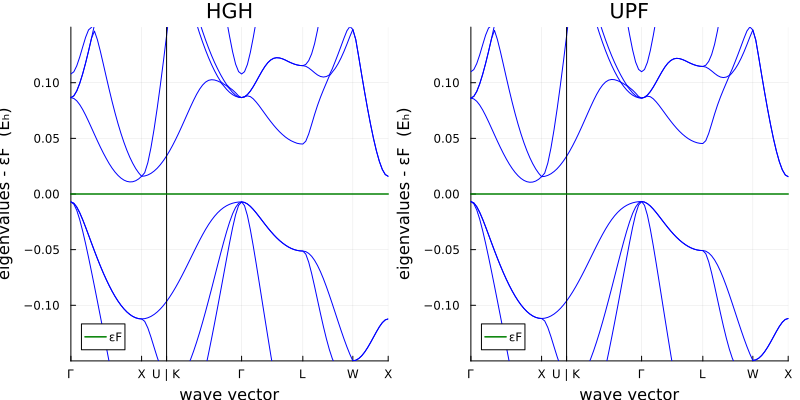

In [6]:
plot(result_hgh.bandplot, result_upf.bandplot, titles=["HGH" "UPF"], size=(800, 400))